In [1]:
#no_preprocessing + conv1d -- 0.92716
#preprocessing + conv1d -- 0.92029

#no_preprocessing + LSTM -- 0.97592
#preprocessing + LSTM -- 

#no_preprocessing + Bi-LSTM -- 0.97647
#preprocessing + Bi-LSTM -- 

In [2]:
import os
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import tensorflow as tf

In [3]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [4]:
def clean_text(text):
    
    data = re.sub('[^a-zA-Z]', ' ', text)
    data = data.lower()
    data = data.split()
    data = [lemmatizer.lemmatize(word) for word in data if word not in stop_words]
    
    return ' '.join(data)

In [5]:
max_seq_len = 100
max_vocab_size = 20000
embedding_dim = 100
validation_split = 0.2
batch_size = 64
epochs = 50

In [6]:
word_embeddings = {}
with open(os.path.join('../input/glove6b100dtxt/glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word_key = values[0]
        word_vector = np.array(values[1:], dtype='float32')
        
        word_embeddings[word_key] = word_vector

In [7]:
len(word_embeddings)

400000

In [8]:
train_df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
train_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [9]:
documents = train_df.comment_text.fillna('DummyValue').values
documents = [clean_text(doc) for doc in documents]
documents = np.array(documents)
targets = train_df[train_df.columns[2:]].values

In [10]:
doc_len_list = [len(d) for d in documents]
max_doc_len = max(doc_len_list)
min_doc_len = min(doc_len_list)
avg_doc_len = sum(doc_len_list)/len(documents)

print(f'max document length: {max_doc_len}')
print(f'min document length: {min_doc_len}')
print(f'Avg document length: {avg_doc_len}')

max document length: 5000
min document length: 0
Avg document length: 243.2702370731524


<function matplotlib.pyplot.show(close=None, block=None)>

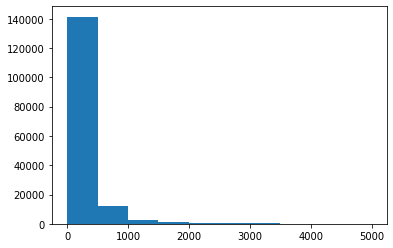

In [11]:
plt.hist(doc_len_list)
plt.show

In [12]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(documents)
sequences = tokenizer.texts_to_sequences(documents)

In [13]:
word_index = tokenizer.word_index
len(word_index)

158697

In [14]:
seq_data = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_seq_len)
seq_data.shape

(159571, 100)

In [15]:
seq_data

array([[    0,     0,     0, ...,     2,    69,  2934],
       [    0,     0,     0, ...,     4,   813,   101],
       [    0,     0,     0, ...,  2077,   600,   345],
       ...,
       [    0,     0,     0, ...,  2436, 11348,  3538],
       [    0,     0,     0, ...,   227,    65,    48],
       [    0,     0,     0, ...,   252,  1401,  1661]], dtype=int32)

In [16]:
num_words = min(max_vocab_size, len(word_index)+1)
num_words

20000

In [17]:
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, idx in word_index.items():
    if idx < max_vocab_size:
        embedding_vector = word_embeddings.get(word)
        
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

In [18]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.55660999, -0.11523   ,  0.32071999, ..., -1.15799999,
         0.58295   ,  0.34836999],
       [-0.92940003,  0.10925   , -0.021222  , ..., -0.92944002,
         0.63875002,  0.38077   ],
       ...,
       [ 0.37322   ,  0.16511001,  0.17619   , ..., -0.12885   ,
        -0.086522  ,  0.27818999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.17038   , -0.49039   ,  0.12893   , ..., -0.1507    ,
        -0.22002999,  0.61094999]])

In [19]:
print(f'shape of the seq_data: {seq_data.shape}')
print(f'shape of the targets: {targets.shape}')
print(f'shape of the embedding_matrix: {embedding_matrix.shape}')

shape of the seq_data: (159571, 100)
shape of the targets: (159571, 6)
shape of the embedding_matrix: (20000, 100)


In [20]:
embedding_layer = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False)

In [21]:
input_ = tf.keras.Input(shape=(max_seq_len,))
x = embedding_layer(input_)

In [22]:
##### Conv1D ##########
'''x = tf.keras.layers.Conv1D(128, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(128, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(128, 3, activation='relu')(x)'''

"x = tf.keras.layers.Conv1D(128, 3, activation='relu')(x)\nx = tf.keras.layers.MaxPooling1D(3)(x)\nx = tf.keras.layers.Conv1D(128, 3, activation='relu')(x)\nx = tf.keras.layers.MaxPooling1D(3)(x)\nx = tf.keras.layers.Conv1D(128, 3, activation='relu')(x)"

In [23]:
##### LSTM ##########
#x = tf.keras.layers.LSTM(50, return_sequences=True)(x)

In [24]:
##### Bi-LSTM ##########
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True))(x)

In [25]:
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
output_ = tf.keras.layers.Dense(6, activation='sigmoid')(x)
model = tf.keras.Model(inputs=input_, outputs=output_)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=5, 
    restore_best_weights=True,
)

In [27]:
history = model.fit(seq_data, targets, batch_size=batch_size, epochs= epochs, validation_split=validation_split, callbacks=[early_stopping])

Epoch 1/50
1995/1995 [==============================] - 33s 14ms/step - loss: 0.0972 - accuracy: 0.9794 - val_loss: 0.0535 - val_accuracy: 0.9756
Epoch 2/50
1995/1995 [==============================] - 27s 14ms/step - loss: 0.0507 - accuracy: 0.9687 - val_loss: 0.0508 - val_accuracy: 0.9927
Epoch 3/50
1995/1995 [==============================] - 27s 14ms/step - loss: 0.0463 - accuracy: 0.9784 - val_loss: 0.0486 - val_accuracy: 0.9648
Epoch 4/50
1995/1995 [==============================] - 28s 14ms/step - loss: 0.0423 - accuracy: 0.9817 - val_loss: 0.0474 - val_accuracy: 0.9914
Epoch 5/50
1995/1995 [==============================] - 27s 14ms/step - loss: 0.0400 - accuracy: 0.9791 - val_loss: 0.0478 - val_accuracy: 0.9850
Epoch 6/50
1995/1995 [==============================] - 28s 14ms/step - loss: 0.0380 - accuracy: 0.9793 - val_loss: 0.0479 - val_accuracy: 0.9875
Epoch 7/50
1995/1995 [==============================] - 27s 14ms/step - loss: 0.0348 - accuracy: 0.9845 - val_loss: 0.0536 -

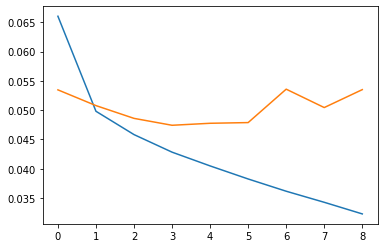

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

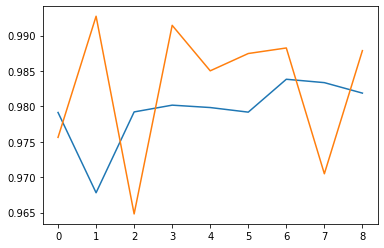

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [30]:
test_df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')
test_data = test_df.comment_text.fillna('DummyValue').values
test_data = [clean_text(doc) for doc in test_data]
test_data = np.array(test_data)
test_ids = test_df.id.values
test_df

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [31]:
test_labels_df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')
test_labels_df

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [32]:
test_sequences = tokenizer.texts_to_sequences(test_data)
test_seq_data = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_seq_len)
preds = model.predict(test_seq_data)
preds

array([[9.8844713e-01, 2.8187656e-01, 9.2102915e-01, 9.4696507e-02,
        8.8433087e-01, 5.6582361e-01],
       [3.8934927e-03, 1.8517316e-05, 7.8147859e-04, 3.5354185e-06,
        8.0510904e-04, 1.3341404e-04],
       [1.6292097e-02, 1.8069784e-04, 2.2519769e-03, 2.0693464e-04,
        5.0894567e-03, 9.0786541e-04],
       ...,
       [7.0239225e-04, 2.3729099e-06, 6.6310400e-05, 1.0978567e-05,
        9.9011013e-05, 2.0508080e-05],
       [5.5383286e-03, 3.0927797e-05, 3.9248378e-04, 3.5349945e-05,
        7.2694424e-04, 4.7823088e-03],
       [9.8571253e-01, 3.9278708e-02, 7.7541369e-01, 6.9189817e-03,
        6.1382020e-01, 8.2404763e-03]], dtype=float32)

In [33]:
preds.shape

(153164, 6)

In [34]:
test_ids.shape

(153164,)

In [35]:
test_ids = test_ids.reshape(-1, 1)
sub_df = pd.DataFrame(preds, columns=train_df.columns[2:])
sub_df['id'] = test_ids
sub_df

,toxic,severe_toxic,obscene,threat,insult,identity_hate,id
0,0.988447,0.281877,0.921029,0.094697,0.884331,0.565824,00001cee341fdb12
1,0.003893,0.000019,0.000781,0.000004,0.000805,0.000133,0000247867823ef7
2,0.016292,0.000181,0.002252,0.000207,0.005089,0.000908,00013b17ad220c46
3,0.000332,0.000001,0.000063,0.000002,0.000060,0.000007,00017563c3f7919a
4,0.001547,0.000006,0.000184,0.000006,0.000207,0.000030,00017695ad8997eb
...,...,...,...,...,...,...,...
153159,0.672628,0.002623,0.106939,0.002219,0.066571,0.001092,fffcd0960ee309b5
153160,0.043315,0.000592,0.004649,0.018833,0.007361,0.002515,fffd7a9a6eb32c16
153161,0.000702,0.000002,0.000066,0.000011,0.000099,0.000021,fffda9e8d6fafa9e
153162,0.005538,0.000031,0.000392,0.000035,0.000727,0.004782,fffe8f1340a79fc2


In [36]:
cols = sub_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
sub_df = sub_df[cols]
sub_df

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.988447,0.281877,0.921029,0.094697,0.884331,0.565824
1,0000247867823ef7,0.003893,0.000019,0.000781,0.000004,0.000805,0.000133
2,00013b17ad220c46,0.016292,0.000181,0.002252,0.000207,0.005089,0.000908
3,00017563c3f7919a,0.000332,0.000001,0.000063,0.000002,0.000060,0.000007
4,00017695ad8997eb,0.001547,0.000006,0.000184,0.000006,0.000207,0.000030
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.672628,0.002623,0.106939,0.002219,0.066571,0.001092
153160,fffd7a9a6eb32c16,0.043315,0.000592,0.004649,0.018833,0.007361,0.002515
153161,fffda9e8d6fafa9e,0.000702,0.000002,0.000066,0.000011,0.000099,0.000021
153162,fffe8f1340a79fc2,0.005538,0.000031,0.000392,0.000035,0.000727,0.004782


In [37]:
sub_df.to_csv('submissioin.csv', index=False, header=True)

In [38]:
#from sklearn.metrics import roc_auc_score
#aucs = []
#for idx in range(6):
#    aucs.append(roc_auc_score(targets[:,idx], preds[:, idx]))
#print(np.mean(aucs))